In [17]:
import pickle 
import numpy as np 
import pandas as pd
import networkx as nx
from tqdm import tqdm
import time
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import ast
from itertools import combinations

In [58]:
movie_path = 'data/Movie.pkl'
actors_path = 'data/Actor.pkl'

with open(movie_path, 'rb') as file:
    Movie = pickle.load(file)

with open(actors_path, 'rb') as file:
    Actors = pickle.load(file)

In [59]:
def create_actor_network(Actors, min_movies=50):
    # Calculate the number of films for each actor
    Actors["Number_of_films"] = Actors["actor_age_atmovierelease"].apply(len)
    
    # Filter actors with at least `min_movies` films
    actors_with_min_x_movies = Actors[Actors["Number_of_films"] > min_movies]
    
    # Explode the DataFrame to have one row per film per actor
    actors_df = actors_with_min_x_movies.explode('Freebase_movie_ID')
    G = nx.Graph()

    # Group by movie ID and create edges for actors in the same movie
    for movie_id, group in actors_df.groupby('Freebase_movie_ID'):
        actor_ids = group['Freebase_actor_ID'].tolist()
        for actor1, actor2 in combinations(actor_ids, 2):
            if actor1 != actor2:
                if G.has_edge(actor1, actor2):
                    G[actor1][actor2]['weight'] += 1
                else:
                    G.add_edge(actor1, actor2, weight=1)

    # Add attributes to each actor node
    for _, row in actors_df.iterrows():
        actor_id = row['Freebase_actor_ID']
        if actor_id in G:
            G.nodes[actor_id].update({
                'name': row['actor_name'],
                'gender': row.get('actor_gender', None),
                'ethnicity': row.get('ethnicity', None),
                'height': row.get('actor_height', None)
            })
    return G, actors_with_min_x_movies
    

In [60]:
start_time = time.time()
G, actors_with_min_x_movies = create_actor_network(Actors, min_movies=10)
print("Created graph with actors:")
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
end_time = time.time()

print("time to compute :", end_time - start_time, "seconds")



Created graph with actors:
Number of nodes: 8510
Number of edges: 466039
time to compute : 12.997702836990356 seconds


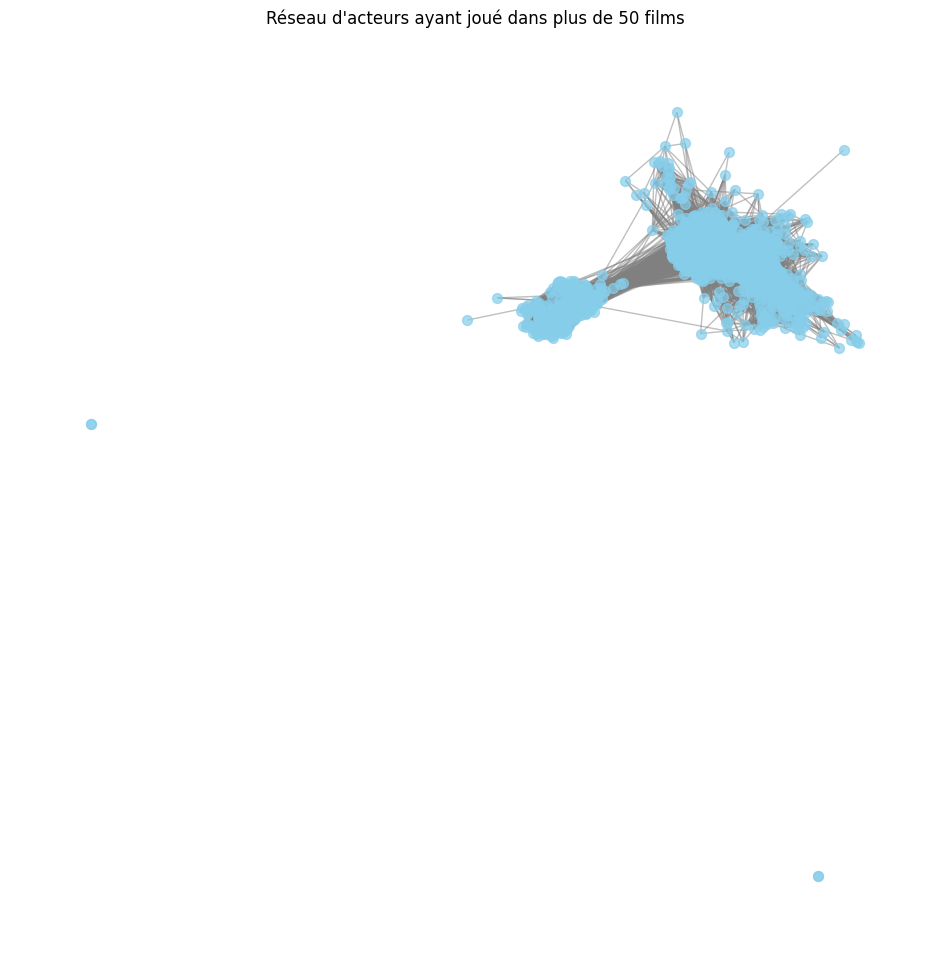

In [21]:
# Créer la position des nœuds pour une meilleure visualisation (utilise l'algorithme de disposition de force)
pos = nx.spring_layout(G, seed=42)  # Utiliser un seed pour des résultats reproductibles
# Autres options de disposition :
#pos = nx.circular_layout(G)
#pos = nx.kamada_kawai_layout(G)
#pos = nx.spectral_layout(G)
node_sizes = [G.degree(node) * 10 for node in G.nodes]

# Taille des arêtes basée sur le poids (nombre de collaborations entre deux acteurs)
#edge_weights = [G[u][v]['weight'] for u, v in G.edges]
edge_weights = 1

# Tracer le graphe
plt.figure(figsize=(12, 12))
nx.draw_networkx_nodes(G, pos, node_size=50, node_color="skyblue", alpha=0.7)
nx.draw_networkx_edges(G, pos, width=edge_weights, alpha=0.5, edge_color="gray")
#nx.draw_networkx_labels(G, pos, {node: G.nodes[node]['name'] for node in G.nodes}, font_size=8)

plt.title("Réseau d'acteurs ayant joué dans plus de 50 films")
plt.axis("off")
plt.show()

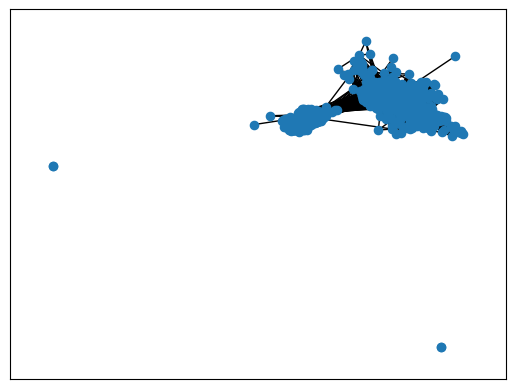

In [22]:
import networkx as nx
import matplotlib.pyplot as plt

sp = nx.spring_layout(G, seed=42)
nx.draw_networkx(G, pos=sp, with_labels=False, node_size=35)
# plt.axes('off')
plt.show()

In [ ]:
pip install python-louvain

In [37]:
import community
import collections

partition = community.best_partition(G)
values = [partition.get(node) for node in G.nodes()]
counter=collections.Counter(values)
print(counter)

Counter({2: 3074, 1: 1884, 5: 1688, 14: 698, 13: 516, 8: 361, 6: 143, 4: 53, 10: 36, 15: 24, 7: 11, 9: 7, 0: 6, 3: 4, 12: 3, 11: 2})


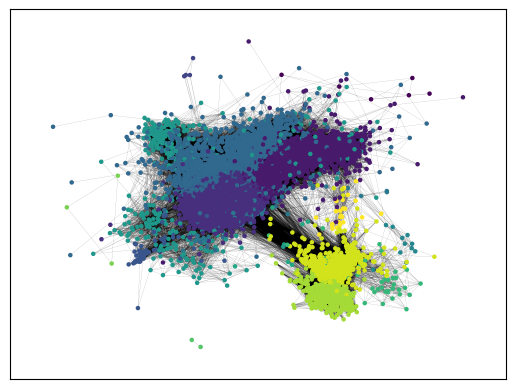

In [38]:
sp = nx.spring_layout(G, k=0.1, seed=42)
nx.draw_networkx(G, pos=sp, with_labels=False, node_size=5, node_color=values, width=0.05)
# plt.axes('off')
plt.show()

In [39]:
partition = community.best_partition(G)
values = [partition.get(node) for node in G.nodes()]
counter = collections.Counter(values)

# Afficher le nombre de clusters
print("Nombre de clusters :", len(counter))

Nombre de clusters : 16


In [61]:
# Convertir le dictionnaire `partition` en une Series Pandas
cluster_series = pd.Series(partition, name="cluster_id")

# Joindre cette Series au DataFrame d'origine `Actors`
#Actors = Actors.join(cluster_series, on='Freebase_actor_ID')
actors_with_min_x_movies = actors_with_min_x_movies.join(cluster_series, on='Freebase_actor_ID')


In [62]:
actors_with_min_x_movies.tail()

,Freebase_actor_ID,actor_name,actor_DOB,actor_gender,actor_height,ethnicity,Freebase_movie_ID,actor_age_atmovierelease,Number_of_films,cluster_id
135747,/m/0y58x,Devon Sawa,1978-09-07,M,1.83,None,"[/m/04j34t9, /m/0gwz12g, /m/093s98, /m/0287pym...","[18.0, 32.0, 24.0, 26.0, 18.0, 15.0, 16.0, 17....",19,1.0
135751,/m/0ywqc,Donald Sutherland,1935-07-17,M,1.93,Scottish Americans,"[/m/0dcjzb, /m/02vxyq9, /m/0h1d4kn, /m/01vg4x,...","[69.0, 68.0, <NA>, 65.0, 34.0, 43.0, 58.0, 40....",112,1.0
135753,/m/0z05l,Graham Greene,1952-06-22,M,1.79,First Nations,"[/m/02x3323, /m/02748ds, /m/093l8p, /m/02rtv28...","[<NA>, 50.0, 52.0, 49.0, 38.0, 45.0, 47.0, 42....",27,1.0
135754,/m/0z4s,Anthony Hopkins,1937-12-31,M,1.74,Irish migration to Great Britain,"[/m/035bcl, /m/03mczbc, /m/07wzcn, /m/0cc7mcr,...","[60.0, 56.0, 39.0, <NA>, 60.0, 60.0, 58.0, 54....",83,4.0
135758,/m/0zcbl,Paul Giamatti,1967-06-06,M,1.74,Irish Americans,"[/m/0ck5rr, /m/04yg13l, /m/04wdfw, /m/03whlgj,...","[38.0, 43.0, 28.0, 41.0, 46.0, 43.0, 28.0, 31....",54,1.0
